In [2]:
import json
import os
import rasterio as rio
import geopandas as gpd
from shapely.geometry import box
from fiona.crs import from_epsg
from rasterio.mask import mask
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '/projects/pygeotools')
from pygeotools.lib import filtlib, iolib, malib, warplib

from osgeo import gdal


In [3]:
## open json
## parses json file and returns local filepaths
## outputs a listof the local filepaths
def GetBandLists(inJSON, bandnum):
    with open(inJSON) as f:
        response = json.load(f)
    
    BandList = []
    for i in range(len(response.keys())):
        try:
            getBand = response['features'][i]['assets']['SR_B' + str(bandnum) + '.TIF']['href']
            BandList.append(getBand)
        except exception as e:
            print(e)
        
    return BandList


BLUEBands = GetBandLists('/projects/alexdevseed/landsat8/local-2018.json', 2)
GREENBands = GetBandLists('/projects/alexdevseed/landsat8/local-2018.json', 3)
REDBands = GetBandLists('/projects/alexdevseed/landsat8/local-2018.json', 4)
NIRBands = GetBandLists('/projects/alexdevseed/landsat8/local-2018.json', 5)
SWIRBands = GetBandLists('/projects/alexdevseed/landsat8/local-2018.json', 6)

print("file locations of red bands over ROI = ", REDBands)
print("file locations of nir bands over ROI = ", NIRBands)


file locations of red bands over ROI =  ['/projects/alexdevseed/landsat8/LC08_L2SP_031029_20180910_20200830_02_T1/LC08_L2SP_031029_20180910_20200830_02_T1_SR_B4.TIF', '/projects/alexdevseed/landsat8/LC08_L2SP_031028_20180910_20200830_02_T1/LC08_L2SP_031028_20180910_20200830_02_T1_SR_B4.TIF', '/projects/alexdevseed/landsat8/LC08_L2SP_031029_20180825_20200831_02_T1/LC08_L2SP_031029_20180825_20200831_02_T1_SR_B4.TIF', '/projects/alexdevseed/landsat8/LC08_L2SP_032028_20180816_20200831_02_T1/LC08_L2SP_032028_20180816_20200831_02_T1_SR_B4.TIF']
file locations of nir bands over ROI =  ['/projects/alexdevseed/landsat8/LC08_L2SP_031029_20180910_20200830_02_T1/LC08_L2SP_031029_20180910_20200830_02_T1_SR_B5.TIF', '/projects/alexdevseed/landsat8/LC08_L2SP_031028_20180910_20200830_02_T1/LC08_L2SP_031028_20180910_20200830_02_T1_SR_B5.TIF', '/projects/alexdevseed/landsat8/LC08_L2SP_031029_20180825_20200831_02_T1/LC08_L2SP_031029_20180825_20200831_02_T1_SR_B5.TIF', '/projects/alexdevseed/landsat8/LC08

In [4]:
## Use pygeotools to warp them all to the same extent
## inputs the list of files from above
## output is a new list of warped objects the size of the entire extent

def WarpRasters(filelist, extent, res, t_srs, r):
    outWarp = warplib.memwarp_multi_fn(filelist, extent='union', res=30, t_srs='first', r='cubic')
    return outWarp

print("Warping rasters to same res/extent/proj")
B_list = WarpRasters(BLUEBands, extent='union', res=30, t_srs='first', r='cubic')
G_list = WarpRasters(GREENBands, extent='union', res=30, t_srs='first', r='cubic')
R_list = WarpRasters(REDBands, extent='union', res=30, t_srs='first', r='cubic')
NIR_list = WarpRasters(NIRBands, extent='union', res=30, t_srs='first', r='cubic')
SWIR_list = WarpRasters(SWIRBands, extent='union', res=30, t_srs='first', r='cubic')

print("finished")

Warping rasters to same res/extent/proj

Warping all inputs to the following:
Resolution: 30.0
Extent: [248385.0, 4819785.0, 604515.0, 5218815.0]
Projection: '+proj=utm +zone=14 +datum=WGS84 +units=m +no_defs '
Resampling alg: cubic

1 of 4: /projects/alexdevseed/landsat8/LC08_L2SP_031029_20180910_20200830_02_T1/LC08_L2SP_031029_20180910_20200830_02_T1_SR_B2.TIF
nl: 13301 ns: 11871 res: 30.000
2 of 4: /projects/alexdevseed/landsat8/LC08_L2SP_031028_20180910_20200830_02_T1/LC08_L2SP_031028_20180910_20200830_02_T1_SR_B2.TIF
nl: 13301 ns: 11871 res: 30.000
3 of 4: /projects/alexdevseed/landsat8/LC08_L2SP_031029_20180825_20200831_02_T1/LC08_L2SP_031029_20180825_20200831_02_T1_SR_B2.TIF
nl: 13301 ns: 11871 res: 30.000
4 of 4: /projects/alexdevseed/landsat8/LC08_L2SP_032028_20180816_20200831_02_T1/LC08_L2SP_032028_20180816_20200831_02_T1_SR_B2.TIF
nl: 13301 ns: 11871 res: 30.000

Warping all inputs to the following:
Resolution: 30.0
Extent: [248385.0, 4819785.0, 604515.0, 5218815.0]
Projecti

In [5]:
## read all bandas as masked arrays
## read each object in each list as a masked array 

def MaskArrays(bandlist):
    arr = []
    for i in range(len(bandlist)):
        arr.append(iolib.ds_getma(bandlist[i]))
        
    return(np.ma.array(arr))

Blue_band_stack = MaskArrays(B_list)
Green_band_stack = MaskArrays(G_list)
Red_band_stack = MaskArrays(R_list)
NIR_band_stack = MaskArrays(NIR_list)
SWIR_band_stack = MaskArrays(SWIR_list)

print(np.shape(Red_band_stack))
print(np.shape(NIR_band_stack))

print(np.max(Red_band_stack))
print(np.max(NIR_band_stack))

test = (NIR_band_stack[0]-Red_band_stack[0])/(NIR_band_stack[0]+Red_band_stack[0])
print(np.shape(test))

(4, 13301, 11871)
(4, 13301, 11871)
53700
56735
(13301, 11871)


In [25]:
## create NDVI layers
## Loopsover lists of bands and calculates NDVI
## creates a new list of NDVI images, one per input scene

def CreateNDVIstack(REDarr, NIRarr):
    NDVIarr = []
    for i in range(np.shape(REDarr)[0]):
        print("Creating NDVI layer " + str(i+1))
        NDVIarr.append((NIRarr[i]-REDarr[i])/(NIRarr[i]+REDarr[i]))

    return np.array(NDVIarr)
        
NDVIstack = CreateNDVIstack(Red_band_stack, NIR_band_stack)
print('finished')


Creating NDVI layer 1
Creating NDVI layer 2
Creating NDVI layer 3
Creating NDVI layer 4
finished


(4, 13301, 11871)
nan
0.0


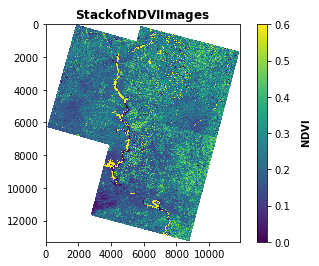

In [41]:
## display NDVI layers over full extent

# mask zero for display
NDVIstack[NDVIstack == 0] = np.nan

print(np.shape(NDVIstack))
print(np.min(NDVIstack))
plt.imshow(NDVIstack[1], cmap='viridis', norm=plt.Normalize(vmin=0, vmax=0.6))
plt.imshow(NDVIstack[2], cmap='viridis', norm=plt.Normalize(vmin=0, vmax=0.6))
plt.imshow(NDVIstack[3], cmap='viridis', norm=plt.Normalize(vmin=0, vmax=0.6))
plt.title(r"$\bf{Stack of NDVI Images}$")
cbar1 = plt.colorbar()
cbar1.ax.set_ylabel(r"$\bf{NDVI}$",  labelpad=10, rotation=90)  
plt.savefig('/projects/bobafett/LandsatComposites/Landsat_NDVImosaic.png', format='PNG')

# put 0s back to avoid all nan slice
where_are_NaNs = np.isnan(NDVIstack)
NDVIstack[where_are_NaNs] = 0
print(np.min(NDVIstack))

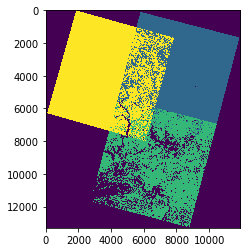

In [35]:
## get the index positions of the max NDVI value
## Get the argmax index positions from the stack of NDVI images

NDVImax = np.nanargmax(NDVIstack,axis=0)

## create a tmp array (binary mask) of the same input shape
NDVItmp = np.zeros(Red_band_stack.shape, dtype=bool)

## for each dimension assign the index position (flattens the array to a LUT)
for i in range(np.shape(Red_band_stack)[0]):
    NDVItmp[i,:,:]=NDVImax==i
    

plt.imshow(NDVImax, cmap='viridis')

In [20]:
## Return Red value based on NDVI max index position

# insert the bands as arrays (made earlier)
## creates a single layer by using the binary mask
## and a sum function to collapse n-dims to 2-dims
def CollapseBands(inArr, NDVItmp):
    inArr[np.logical_not(NDVItmp)]=0 
    compImg = inArr.sum(0)
    
    return compImg
    

BlueComp=CollapseBands(Blue_band_stack, NDVItmp)
GreenComp=CollapseBands(Green_band_stack, NDVItmp)
RedComp=CollapseBands(Red_band_stack, NDVItmp)
NIRComp=CollapseBands(NIR_band_stack, NDVItmp)
SWIRComp=CollapseBands(SWIR_band_stack, NDVItmp)
print(np.shape(BlueComp))

NameError: name 'NDVItmp' is not defined

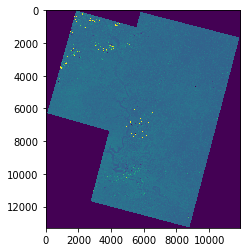

In [9]:
plt.imshow(BlueComp, cmap='viridis', norm=plt.Normalize(vmin=0, vmax=25000))

In [10]:
# Check Geotranform of all bands
print(B_list[0].GetGeoTransform())
print(G_list[0].GetGeoTransform())
print(R_list[0].GetGeoTransform())
print(NIR_list[0].GetGeoTransform())
print(SWIR_list[0].GetGeoTransform())



(248385.0, 30.0, 0.0, 5218815.0, 0.0, -30.0)
(248385.0, 30.0, 0.0, 5218815.0, 0.0, -30.0)
(248385.0, 30.0, 0.0, 5218815.0, 0.0, -30.0)
(248385.0, 30.0, 0.0, 5218815.0, 0.0, -30.0)
(248385.0, 30.0, 0.0, 5218815.0, 0.0, -30.0)


In [11]:
## Create Indices of interest from new composites

print("calculating NDVI...")
NDVIComp = (NIRComp - RedComp)/(NIRComp + RedComp)
print("calculating SAVI...")
SAVIComp = ((NIRComp - RedComp)/(NIRComp + RedComp +0.5))*1.5
print("calculating Red edge (Simple ratio)...")
REComp = NIRComp - RedComp
print("calculating EVI...")
EVIComp = 2.5 * ((NIRComp - RedComp) / (NIRComp + 6 * RedComp - 7.5 * BlueComp + 1))
print("calculating NDMI...")
NDMIComp = (NIRComp - SWIRComp) / (NIRComp + SWIRComp)


calculating NDVI...
calculating SAVI...
calculating Red edge (Simple ratio)...
calculating EVI...
calculating NDMI...


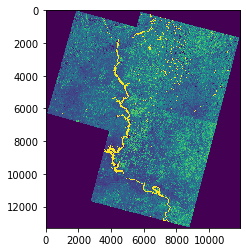

In [12]:
## plot the transformations

plt.imshow(SAVIComp, cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))

In [13]:
## Stack bands to write out RGB
ReflectanceStack = np.array([BlueComp, GreenComp, RedComp, NIRComp, SWIRComp])
IndicesStack = np.array([NDVIComp, SAVIComp, REComp, EVIComp, NDMIComp])
print(np.shape(IndicesStack))

(5, 13301, 11871)


In [ ]:
# Write arrays to multiband image

from osgeo import gdal, osr
import os
import io
import numpy as np

def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array,driver,outtype, names):

    bands = array.shape[0]
    print('number of bands: ', bands)
    rows = array.shape[1]
    cols = array.shape[2]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]
    driver = gdal.GetDriverByName(driver)
    #Here is where I assign three bands to the raster with int 3
    option=['COMPRESS=LZW']
    outRaster = driver.Create(newRasterfn, cols, rows, bands, outtype, options=option)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    #outband = outRaster.GetRasterBand(1)
    #outband.WriteArray(array)
    for band in range(bands):
        print("Processing band :", names[band])
        outRaster.SetDescription(names[band])
        outRaster.GetRasterBand(band+1).WriteArray( array[band, :, :] )

    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(4326)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outRaster.FlushCache()
    
    return outRaster

ReflectanceOutput = "/projects/bobafett/LandsatComposites/LS8_GC_2018_refl.tif"
IndicesOutput = "/projects/bobafett/LandsatComposites/LS8_GC_2018_idx.tif"

geotransform = B_list[0].GetGeoTransform()
rasterOrigin=[geotransform[0], geotransform[3]]
pixelW = geotransform[1]
pixelH = geotransform[5]

#outRaster = array2raster(ReflectanceOutput,rasterOrigin, pixelW, pixelH, ReflectanceStack, 'GTiff', gdal.GDT_UInt16, ['Blue', 'Green', 'Red', 'NIR', 'SWIR'])
outRaster = array2raster(IndicesOutput,rasterOrigin, pixelW, pixelH, IndicesStack, 'GTiff', gdal.GDT_Float32, ['NDVI', 'SAVI', 'RE', 'EVI', 'NDMI'])
print('finished')

0


In [ ]:
## OLD CODE

## read json

#with open('/projects/alexdevseed/landsat8/local-2020.json') as f:
#    response = json.load(f)

## Collate Blue bands
#BLUEBands = []
#for i in range(len(response.keys())):
#    BLUEBands.append(response['features'][0]['assets']['SR_B2.TIF']['href'])

## Get list of GDALobjects
#B_list = warplib.memwarp_multi_fn(BLUEBands, extent='union', res=30, t_srs='first', r='cubic')

## For each GDAL object get masked array
#Blue1 = iolib.ds_getma(B_list[0])
#Blue2 = iolib.ds_getma(B_list[1])
#Blue3 = iolib.ds_getma(B_list[2])
#Blue4 = iolib.ds_getma(B_list[3])

#Green1 = iolib.ds_getma(G_list[0])
#Green2 = iolib.ds_getma(G_list[1])
#Green3 = iolib.ds_getma(G_list[2])
#Green4 = iolib.ds_getma(G_list[3])

#Red1 = iolib.ds_getma(R_list[0])
#Red2 = iolib.ds_getma(R_list[1])
#Red3 = iolib.ds_getma(R_list[2])
#Red4 = iolib.ds_getma(R_list[3])

#NIR1 = iolib.ds_getma(NIR_list[0])
#NIR2 = iolib.ds_getma(NIR_list[1])
#NIR3 = iolib.ds_getma(NIR_list[2])
#NIR4 = iolib.ds_getma(NIR_list[3])

#SWIR1 = iolib.ds_getma(SWIR_list[0])
#SWIR2 = iolib.ds_getma(SWIR_list[1])
#SWIR3 = iolib.ds_getma(SWIR_list[2])
#SWIR4 = iolib.ds_getma(SWIR_list[3])


## create NDVI layers

#NDVI1 = (NIR1-Red1)/(NIR1+Red1)
#NDVI2 = (NIR2-Red2)/(NIR2+Red2)
#NDVI3 = (NIR3-Red3)/(NIR3+Red3)
#NDVI4 = (NIR4-Red4)/(NIR4+Red4)

## stack the individual bands together

#BlueStack = np.ma.array([Blue1, Blue2, Blue3, Blue4])
#GreenStack = np.ma.array([Green1, Green2, Green3, Green4])
#RedStack = np.ma.array([Red1, Red2, Red3, Red4])
#NIRStack = np.ma.array([NIR1, NIR2, NIR3, NIR4])
#SWIRStack = np.ma.array([SWIR1, SWIR2, SWIR3, SWIR4])

## get the index positions of the max NDVI value

#NDVImax = np.nanargmax((NDVI1,NDVI2,NDVI3,NDVI4),axis=0)

#NDVItmp = np.zeros(RedStack.shape, dtype=bool)

#for i in range(np.shape(RedStack)[0]):
#    NDVItmp[i,:,:]=NDVImax==i


## Return Red value based on NDVI max index position

#RedComposite[NDVItmp] = RedStack[NDVItmp]
#BlueStack[np.logical_not(NDVItmp)]=0
#BlueComp=BlueStack.sum(0)

#GreenStack[np.logical_not(NDVItmp)]=0
#GreenComp=GreenStack.sum(0)

#RedStack[np.logical_not(NDVItmp)]=0
#RedComp=RedStack.sum(0)

#NIRStack[np.logical_not(NDVItmp)]=0
#NIRComp=NIRStack.sum(0)

#SWIRStack[np.logical_not(NDVItmp)]=0
#SWIRComp=SWIRStack.sum(0)

## Ends up with Composite Images